# Phase 2
## Combined Analysis of Apple Health Menstrual Flow and Wrist Temperature Data
- Import and normalize menstrual flow tracking data
- Visualize thermal shift computation function, average temperature on each cycle day, and temperature distribution across cycle phases
- Compute key statistics on cycle and phase durations

In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded!")

Libraries loaded!


In [2]:
# 2. Load Cleaned Data from Phase 1
df_clean = pd.read_csv('../data/processed/temperature_clean_no_outliers.csv')

# Convert effectiveDate back to datetime
df_clean['effectiveDate'] = pd.to_datetime(df_clean['effectiveDate'])

# Sort by date
df_clean = df_clean.sort_values('effectiveDate').reset_index(drop=True)

print(f"Loaded {len(df_clean)} temperature readings")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")
df_clean.head()

Loaded 1205 temperature readings
Date range: 0 to 1204


,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion,effectiveDate
0,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-05 03:30:01+00:00,2022-10-05 11:01:00+00:00,degF,97.062257,1.0,2022-10-05
1,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-06 02:56:16+00:00,2022-10-06 11:37:07+00:00,degF,97.059470,1.0,2022-10-06
2,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-07 03:04:03+00:00,2022-10-07 11:00:21+00:00,degF,97.222864,1.0,2022-10-07
3,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-08 04:00:01+00:00,2022-10-08 14:48:59+00:00,degF,97.503098,1.0,2022-10-08
4,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-09 04:00:00+00:00,2022-10-09 12:47:03+00:00,degF,97.664851,1.0,2022-10-09


In [3]:
# 3. Menstruation Date Tracking - Import
df_mens_raw = pd.read_csv('../data/raw/HKCategoryTypeIdentifierMenstrualFlow_2026-01-26_10-30-16_SimpleHealthExportCSV.csv', skiprows=1)

print(f"Data loaded: {df_mens_raw.shape[0]} rows, {df_mens_raw.shape[1]} columns")
df_mens_raw.head()

Data loaded: 367 rows, 10 columns


,type,sourceName,sourceVersion,productType,device,startDate,endDate,value,HKWasUserEntered,HKMenstrualCycleStart
0,HKCategoryTypeIdentifierMenstrualFlow,Health,13.5.1,"iPhone11,2",NaN,2020-07-15 16:00:00 +0000,2020-07-15 16:00:00 +0000,unspecified,1.0,1
1,HKCategoryTypeIdentifierMenstrualFlow,Health,13.5.1,"iPhone11,2",NaN,2020-07-16 16:00:00 +0000,2020-07-16 16:00:00 +0000,unspecified,1.0,0
2,HKCategoryTypeIdentifierMenstrualFlow,Health,13.5.1,"iPhone11,2",NaN,2020-07-17 16:00:00 +0000,2020-07-17 16:00:00 +0000,unspecified,1.0,0
3,HKCategoryTypeIdentifierMenstrualFlow,Health,13.5.1,"iPhone11,2",NaN,2020-07-18 16:00:00 +0000,2020-07-18 16:00:00 +0000,unspecified,1.0,0
4,HKCategoryTypeIdentifierMenstrualFlow,Health,13.5.1,"iPhone11,2",NaN,2020-07-19 16:00:00 +0000,2020-07-19 16:00:00 +0000,unspecified,1.0,0


In [4]:
# 4. Menstruation Date Tracking - Cleaning
df_mens_starts = df_mens_raw.loc[df_mens_raw['HKMenstrualCycleStart'] == 1].reset_index(drop=True)
# Convert date columns to datetime (adjust column name to match your data)
df_mens_starts['startDate'] = pd.to_datetime(df_mens_starts['startDate'])
df_mens_starts['endDate'] = pd.to_datetime(df_mens_starts['endDate'])

# Remove dates before the temperature tracking range
first_temp_date = pd.to_datetime(df_clean['effectiveDate']).min().tz_localize(None)
df_mens_starts = df_mens_starts.loc[df_mens_starts['startDate'].dt.tz_localize(None) > first_temp_date].reset_index(drop=True)

# Create an Effective Date column to peg the measurement to a single day.
df_mens_starts['effectiveDate'] = df_mens_starts['startDate'].dt.date
df_mens_starts = df_mens_starts.sort_values('effectiveDate').reset_index(drop=True)

# Extract just the dates as a Series for easier processing
cycle_starts = df_mens_starts['effectiveDate'].sort_values().drop_duplicates().reset_index(drop=True)

print(f"Loaded {len(cycle_starts)} cycle start dates")
print(f"Date range: {cycle_starts.min()} to {cycle_starts.max()}")
print("\nFirst few cycle starts:")
print(cycle_starts.head(10))

Loaded 42 cycle start dates
Date range: 2022-10-25 to 2026-01-03

First few cycle starts:
0    2022-10-25
1    2022-11-21
2    2022-12-21
3    2023-01-17
4    2023-02-13
5    2023-03-13
6    2023-04-09
7    2023-05-08
8    2023-06-07
9    2023-07-06
Name: effectiveDate, dtype: object


In [5]:
# 5: Calculate Cycle Day Function
def calculate_cycle_day(date, cycle_starts_series):
    """
    Calculate which cycle day a given date falls on.
    
    Parameters:
    - date: The date to calculate cycle day for
    - cycle_starts: Pandas Series of cycle start dates (sorted)
    
    Returns:
    - cycle_day: Day number in current cycle (1, 2, 3...)
    - cycle_number: Which cycle this belongs to (1, 2, 3...)
    """
    date = date.date()
    
    # Find the most recent cycle start before or on this date
    previous_starts = cycle_starts[cycle_starts <= date]
    
    if len(previous_starts) == 0:
        return None, None  # Date is before first tracked cycle
    
    current_cycle_start = previous_starts.iloc[-1]
    
    # Find which cycle number this is (1-indexed)
    cycle_number = cycle_starts[cycle_starts == current_cycle_start].index[0] + 1
    
    # Calculate days since cycle start (cycle day 1 = start date)
    cycle_day = (date - current_cycle_start).days + 1
    
    return cycle_day, cycle_number

# Test the function
test_date = df_clean['effectiveDate'].iloc[-1]
cycle_day, cycle_num = calculate_cycle_day(test_date, cycle_starts)
print(f"\nTest: {test_date.date()} is cycle day {cycle_day} of cycle {cycle_num}")


Test: 2026-01-26 is cycle day 24 of cycle 42


In [6]:
# 6. Apply Cycle Day Calculation to All Data

# Apply function to each row
df_clean[['cycle_day', 'cycle_number']] = df_clean['effectiveDate'].apply(
    lambda x: pd.Series(calculate_cycle_day(x, cycle_starts))
)

# Remove rows before first cycle start (if any)
df_clean = df_clean.dropna(subset=['cycle_day'])

# Convert to integers
df_clean['cycle_day'] = df_clean['cycle_day'].astype(int)
df_clean['cycle_number'] = df_clean['cycle_number'].astype(int)

print(f"Cycle days calculated for {len(df_clean)} readings")
print(f"\nCycle day range: {df_clean['cycle_day'].min()} to {df_clean['cycle_day'].max()}")
print(f"Number of cycles: {df_clean['cycle_number'].nunique()}")

df_clean.head(10)

Cycle days calculated for 1185 readings

Cycle day range: 1 to 33
Number of cycles: 42


,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion,effectiveDate,cycle_day,cycle_number
20,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-25 03:30:01+00:00,2022-10-25 12:34:39+00:00,degF,97.104074,1.0,2022-10-25,1,1
21,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-26 03:30:00+00:00,2022-10-26 11:10:57+00:00,degF,97.425802,1.0,2022-10-26,2,1
22,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-27 03:30:03+00:00,2022-10-27 12:30:09+00:00,degF,97.435223,1.0,2022-10-27,3,1
23,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-28 05:17:47+00:00,2022-10-28 12:59:33+00:00,degF,97.569482,1.0,2022-10-28,4,1
24,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-10-29 04:16:34+00:00,2022-10-29 13:04:38+00:00,degF,97.344888,1.0,2022-10-29,5,1
25,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-10-30 04:55:00+00:00,2022-10-30 13:23:07+00:00,degF,97.173494,1.0,2022-10-30,6,1
26,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-10-31 03:30:00+00:00,2022-10-31 11:03:48+00:00,degF,96.859786,1.0,2022-10-31,7,1
27,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-11-01 03:30:00+00:00,2022-11-01 12:30:35+00:00,degF,97.359238,1.0,2022-11-01,8,1
28,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-11-02 04:07:17+00:00,2022-11-02 12:42:44+00:00,degF,97.538762,1.0,2022-11-02,9,1
29,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-11-03 01:40:44+00:00,2022-11-03 11:14:21+00:00,degF,97.336655,1.0,2022-11-03,10,1


In [7]:
# 7. Calculate Cycle Lengths
cycle_lengths = []

for i in range(len(cycle_starts) - 1):
    length = (cycle_starts[i + 1] - cycle_starts[i]).days
    cycle_lengths.append(length)

cycle_length_stats = {
    'Mean': np.mean(cycle_lengths),
    'Median': np.median(cycle_lengths),
    'Std Dev': np.std(cycle_lengths),
    'Min': np.min(cycle_lengths),
    'Max': np.max(cycle_lengths)
}

print("=== Cycle Length Statistics ===")
for stat, value in cycle_length_stats.items():
    print(f"{stat}: {value:.1f} days")

print(f"\nIndividual cycle lengths: {cycle_lengths}")

=== Cycle Length Statistics ===
Mean: 28.4 days
Median: 28.0 days
Std Dev: 2.1 days
Min: 24.0 days
Max: 33.0 days

Individual cycle lengths: [27, 30, 27, 27, 28, 27, 29, 30, 29, 30, 28, 29, 31, 32, 30, 32, 27, 29, 26, 28, 25, 28, 27, 27, 26, 28, 30, 33, 28, 28, 28, 26, 29, 31, 25, 29, 29, 27, 29, 24, 33]


In [8]:
# 8. Add Rolling Averages
# 3-day rolling average (smooths daily noise)
df_clean['temp_3day_avg'] = df_clean['value'].rolling(window=3, center=True).mean()

print("Rolling averages calculated!")
print("\nSample with rolling averages:")
df_clean[['effectiveDate', 'value', 'temp_3day_avg']].head(10)

Rolling averages calculated!

Sample with rolling averages:


,effectiveDate,value,temp_3day_avg
20,2022-10-25,97.104074,NaN
21,2022-10-26,97.425802,97.321700
22,2022-10-27,97.435223,97.476836
23,2022-10-28,97.569482,97.449864
24,2022-10-29,97.344888,97.362621
25,2022-10-30,97.173494,97.126056
26,2022-10-31,96.859786,97.130840
27,2022-11-01,97.359238,97.252596
28,2022-11-02,97.538762,97.411552
29,2022-11-03,97.336655,97.462018


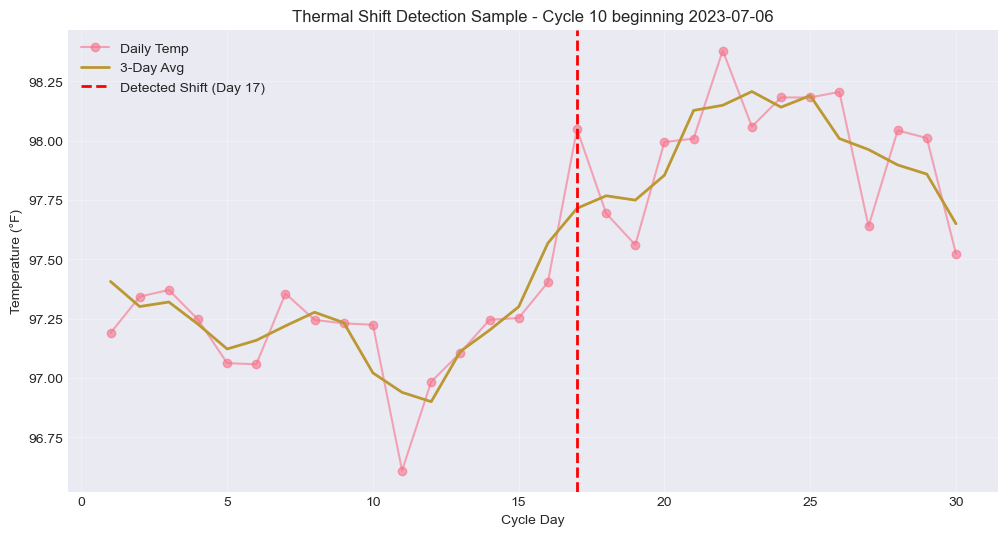

In [9]:
# Compute cycle shift day

def detect_luteal_shift_smooth(cycle_data, baseline_threshold=0.4):
    """
    Use 3-day rolling average for smoother detection.
    """
    # Calculate baseline from rolling average
    follicular_data = cycle_data[cycle_data['cycle_day'] <= 10]
    baseline_temp = follicular_data['temp_3day_avg'].mean()
    threshold_temp = baseline_temp + baseline_threshold
    
    # print(f"Baseline (3-day avg): {baseline_temp:.2f}°F")
    # print(f"Threshold: {threshold_temp:.2f}°F")
    
    # Find first day where 3-day average crosses threshold
    elevated_days = cycle_data[
        (cycle_data['cycle_day'] >= 11) & 
        (cycle_data['temp_3day_avg'] >= threshold_temp)
    ]
    
    if len(elevated_days) > 0:
        shift_day = elevated_days['cycle_day'].min()
        # print(f"Shift detected at day {shift_day} (using 3-day average)")
        return shift_day
    
    # print("No shift detected")
    return None

# Get data for one specific cycle
cycle_1_data = df_clean[df_clean['cycle_number'] == 10].copy()

# Test the smooth version
shift_day = detect_luteal_shift_smooth(cycle_1_data)

# Visualize the result
if shift_day:
    plt.figure(figsize=(12, 6))
    plt.plot(cycle_1_data['cycle_day'], cycle_1_data['value'], 
             'o-', alpha=0.6, label='Daily Temp')
    plt.plot(cycle_1_data['cycle_day'], cycle_1_data['temp_3day_avg'], 
             linewidth=2, label='3-Day Avg')
    plt.axvline(shift_day, color='red', linestyle='--', 
                linewidth=2, label=f'Detected Shift (Day {shift_day})')
    plt.xlabel('Cycle Day')
    plt.ylabel('Temperature (°F)')
    plt.title(f"Thermal Shift Detection Sample - Cycle {cycle_1_data['cycle_number'].iloc[0]} beginning {cycle_1_data['effectiveDate'].dt.strftime('%Y-%m-%d').min()}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Couldn't find data for the specified sample cycle!")

In [10]:
# 6. Apply Temp Shift Day Calculation to All Data

shift_results = []

for cycle_num in df_clean['cycle_number'].unique():
    cycle_data = df_clean[df_clean['cycle_number'] == cycle_num].copy()
    shift_day = detect_luteal_shift_smooth(cycle_data)
    
    if shift_day is not None:
        # Get baseline and post-shift temperatures for this cycle
        follicular = cycle_data[cycle_data['cycle_day'] <= 10]['value'].mean()
        luteal = cycle_data[cycle_data['cycle_day'] >= shift_day]['value'].mean()
        temp_rise = luteal - follicular
        
        shift_results.append({
            'cycle_number': cycle_num,
            'shift_day': shift_day,
            'baseline_temp': follicular,
            'luteal_temp': luteal,
            'temp_rise': temp_rise
        })

# Create DataFrame of results
df_shifts = pd.DataFrame(shift_results)

print("=== Thermal Shift Detection Results ===\n")
print(f"Cycles analyzed: {len(df_clean['cycle_number'].unique())}")
print(f"Shifts detected: {len(df_shifts)}")
print(f"Detection rate: {len(df_shifts) / len(df_clean['cycle_number'].unique()) * 100:.1f}%")

if len(df_shifts) > 0:
    print(f"\n=== Average Shift Statistics ===")
    print(f"Average shift day: {df_shifts['shift_day'].mean():.0f}")
    print(f"Median shift day: {df_shifts['shift_day'].median():.0f}")
    print(f"Std deviation: {df_shifts['shift_day'].std():.1f} days")
    print(f"Range: Day {df_shifts['shift_day'].min():.0f} to Day {df_shifts['shift_day'].max():.0f}")
    
    print(f"\n=== Temperature Changes ===")
    print(f"Average baseline temp: {df_shifts['baseline_temp'].mean():.2f}°F")
    print(f"Average luteal temp: {df_shifts['luteal_temp'].mean():.2f}°F")
    print(f"Average temperature rise: {df_shifts['temp_rise'].mean():.2f}°F")
    
    print("\n=== Individual Cycle Results ===")
    display(df_shifts)
else:
    print(f"Couldn't build table of temperature shifts, this was the result instead: {df_shifts}")

=== Thermal Shift Detection Results ===

Cycles analyzed: 42
Shifts detected: 42
Detection rate: 100.0%

=== Average Shift Statistics ===
Average shift day: 17
Median shift day: 17
Std deviation: 3.1 days
Range: Day 11 to Day 26

=== Temperature Changes ===
Average baseline temp: 97.23°F
Average luteal temp: 97.94°F
Average temperature rise: 0.71°F

=== Individual Cycle Results ===


,cycle_number,shift_day,baseline_temp,luteal_temp,temp_rise
0,1,18,97.314740,98.085709,0.770969
1,2,19,97.496840,98.114118,0.617278
2,3,15,97.390634,98.255438,0.864804
3,4,16,97.506880,98.140174,0.633293
4,5,20,97.554470,98.127826,0.573356
5,6,15,97.227113,98.093962,0.866849
6,7,19,97.309190,97.959201,0.650010
7,8,11,97.207773,97.937973,0.730201
8,9,16,97.425316,98.055976,0.630660
9,10,17,97.232480,97.966842,0.734362


In [11]:
# Update the main table with phase name based on cycle shift lookup
def assign_cycle_phase(row):
    """
    Assign cycle phase based on detected shift day for this cycle.
    If shift not detected, fall back to the average.
    """
    cycle_num = row['cycle_number']
    cycle_day = row['cycle_day']
    
    # Look up the shift day for this cycle
    shift_info = df_shifts[df_shifts['cycle_number'] == cycle_num]
    
    if len(shift_info) > 0:
        shift_day = shift_info['shift_day'].iloc[0]
        return 'Follicular' if cycle_day < shift_day else 'Luteal'
    else:
        # Fallback to average if no shift detected for this cycle
        return 'Follicular' if cycle_day <= df_shifts['shift_day'].mean() else 'Luteal'

# Apply the function
df_clean['cycle_phase'] = df_clean.apply(assign_cycle_phase, axis=1)
df_clean.head()

,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion,effectiveDate,cycle_day,cycle_number,temp_3day_avg,cycle_phase
20,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-25 03:30:01+00:00,2022-10-25 12:34:39+00:00,degF,97.104074,1.0,2022-10-25,1,1,NaN,Follicular
21,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-26 03:30:00+00:00,2022-10-26 11:10:57+00:00,degF,97.425802,1.0,2022-10-26,2,1,97.321700,Follicular
22,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-27 03:30:03+00:00,2022-10-27 12:30:09+00:00,degF,97.435223,1.0,2022-10-27,3,1,97.476836,Follicular
23,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0.2,"Watch6,16","<<HKDevice: 0x148b31860>, name:Apple Watch, ma...",2022-10-28 05:17:47+00:00,2022-10-28 12:59:33+00:00,degF,97.569482,1.0,2022-10-28,4,1,97.449864,Follicular
24,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.1,"Watch6,16","<<HKDevice: 0x148b33930>, name:Apple Watch, ma...",2022-10-29 04:16:34+00:00,2022-10-29 13:04:38+00:00,degF,97.344888,1.0,2022-10-29,5,1,97.362621,Follicular


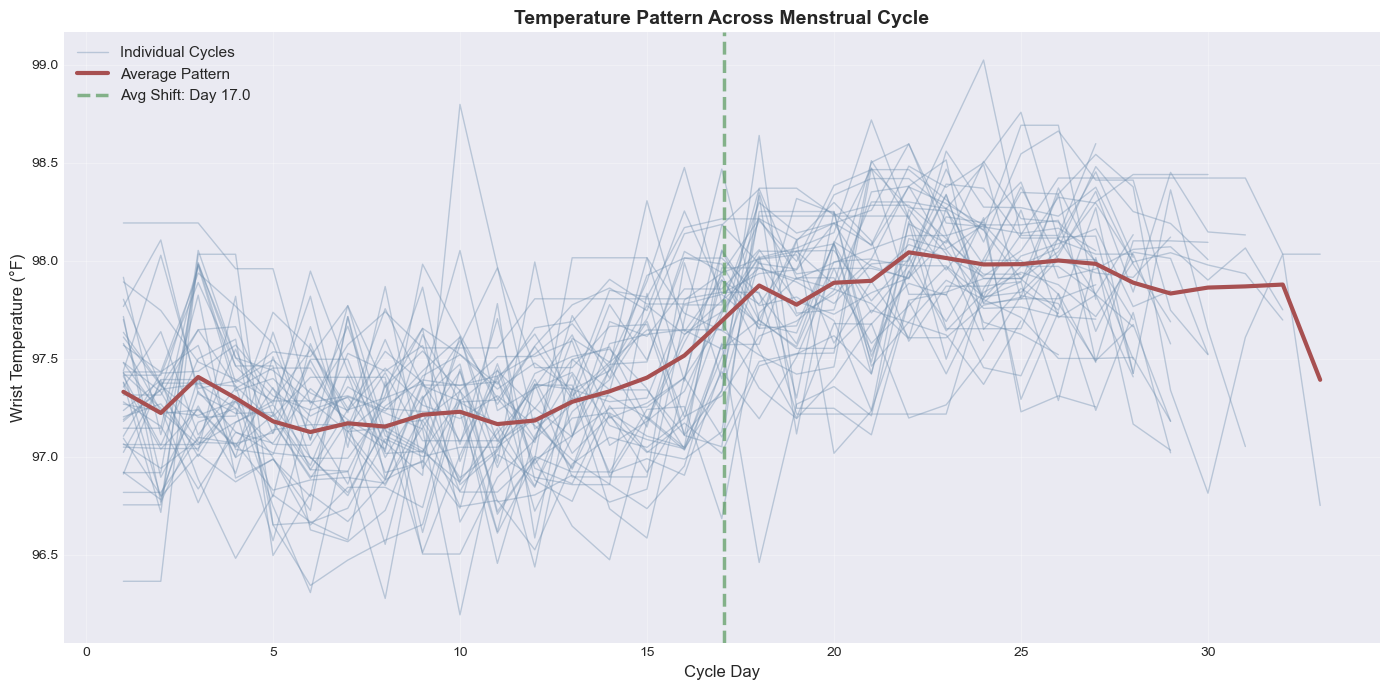

In [12]:
# 8. Visualization - Temperature by Cycle Day
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each cycle separately (without labels for individual cycles)
for cycle_num in df_clean['cycle_number'].unique():
    cycle_data = df_clean[df_clean['cycle_number'] == cycle_num]
    ax.plot(cycle_data['cycle_day'], cycle_data['value'], 
            alpha=0.4, linewidth=1, color='#6f8faf')  # Removed label parameter

# Add one invisible line for the legend entry
ax.plot([], [], alpha=0.4, linewidth=1, color='#6f8faf', label='Individual Cycles')

# Plot average across all cycles
avg_by_cycle_day = df_clean.groupby('cycle_day')['value'].mean()
ax.plot(avg_by_cycle_day.index, avg_by_cycle_day.values, 
        color='#a75051', linewidth=3, label='Average Pattern', zorder=10)

# Add vertical line at the calculated average cycle shift day
avg_shift_day = df_shifts['shift_day'].mean()
ax.axvline(x=avg_shift_day, color='#589a5d', linestyle='--', 
           linewidth=2.5, alpha=0.7, label=f'Avg Shift: Day {avg_shift_day:.1f}')

# Set labels and title
ax.set_xlabel('Cycle Day', fontsize=12)
ax.set_ylabel('Wrist Temperature (°F)', fontsize=12)
ax.set_title('Temperature Pattern Across Menstrual Cycle', fontsize=14, fontweight='bold')

# Create cleaner legend
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig('../outputs/figures/temperature_by_cycle_day.png', 
            dpi=300, bbox_inches='tight')

In [13]:
# Statistical Comparison of Phases
follicular_temps = df_clean[df_clean['cycle_phase'] == 'Follicular']['value']
luteal_temps = df_clean[df_clean['cycle_phase'] == 'Luteal']['value']

print("=== Temperature Comparison by Phase ===\n")

print("Follicular Phase (Days 1-14):")
print(f"  Mean: {follicular_temps.mean():.2f}°F")
print(f"  Std Dev: {follicular_temps.std():.2f}°F")
print(f"  N: {len(follicular_temps)} readings")

print("\nLuteal Phase (Days 15+):")
print(f"  Mean: {luteal_temps.mean():.2f}°F")
print(f"  Std Dev: {luteal_temps.std():.2f}°F")
print(f"  N: {len(luteal_temps)} readings")

print(f"\nTemperature Shift: {luteal_temps.mean() - follicular_temps.mean():.2f}°F")

=== Temperature Comparison by Phase ===

Follicular Phase (Days 1-14):
  Mean: 97.25°F
  Std Dev: 0.36°F
  N: 671 readings

Luteal Phase (Days 15+):
  Mean: 97.93°F
  Std Dev: 0.35°F
  N: 514 readings

Temperature Shift: 0.68°F


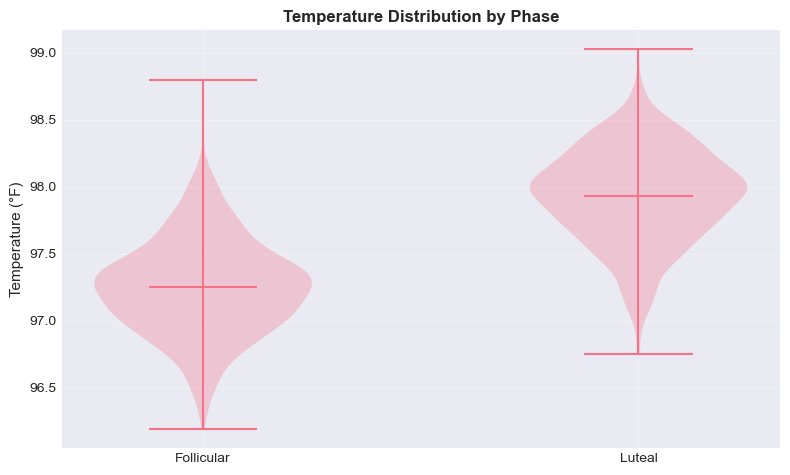

In [14]:
# 11 - Temperature Distribution by Cycle Phase

fig, ax = plt.subplots(figsize=(8, 5))

# Violin plot
parts = ax.violinplot(
    [df_clean[df_clean['cycle_phase'] == 'Follicular']['value'].dropna(),
     df_clean[df_clean['cycle_phase'] == 'Luteal']['value'].dropna()],
    positions=[1, 2],
    showmeans=True,
    showmedians=False
)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Follicular', 'Luteal'])
ax.set_ylabel('Temperature (°F)', fontsize=11)
ax.set_title('Temperature Distribution by Phase', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('')  # Remove auto-generated title
plt.tight_layout()
plt.show()

fig.savefig('../outputs/figures/temperature_by_phase.png', 
            dpi=300, bbox_inches='tight')

In [15]:
# 13. Save Enhanced Dataset
df_clean.to_csv('../data/processed/temperature_with_cycle_data.csv', index=False)

print("Enhanced dataset saved!")
print(f"\nNew columns added:")
print(f"  - cycle_day")
print(f"  - cycle_number")
print(f"  - cycle_phase")
print(f"  - temp_3day_avg")

Enhanced dataset saved!

New columns added:
  - cycle_day
  - cycle_number
  - cycle_phase
  - temp_3day_avg


## Phase 2 Key Findings

**Data Quality**
No significant issues were encountered with the imported cycle dates. Data was complete when filtered for the same date range as the temperature data.

**Cycle Tracking:**
- Average cycle length: 28 days
- Number of complete cycles: 42
- Cycle day range: 24 to 33

Results on par with other healthy individuals.

**Temperature Patterns:**
- Follicular phase average: 97.25°F
- Luteal phase average: 97.93°F
- Temperature shift: +0.68°F
- Average cycle day of shift: 17
- Standard deviation of cycle shift: 3.1 days

The typical temperature shift in the healthy population is commonly cited as 0.4-1°F across cycle phases.
My average shift day (17) is later than the commonly cited typical day (14).

**Closing Notes:**
I found that aggregating and normalizing wrist temperature data over time results in cycle metrics within the parameters of typical clinical metrics. I could further analyze fluctuations in temperature data by comparing with other Apple Health exports such as heart rate and sleep tracking, to see if there is any correlation with fluctuations in those datasets.